# Voting Classifiers


In [1]:
from sklearn.datasets import make_moons;from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression;from sklearn.svm import SVC;
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split


X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



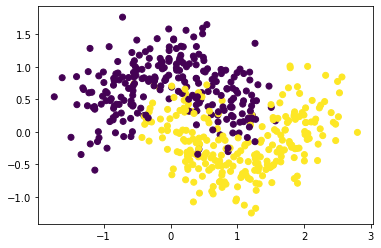

In [2]:
import matplotlib.pyplot as plt;from sklearn.pipeline import Pipeline

plt.scatter(X[:,0],X[:,1],c=y)

### Este es el conjunto de datos sobre el que se pretende entrenar los modelos individuales y el conjunto de ellos por medio de VotingClassfier

In [3]:
from sklearn.metrics import accuracy_score

lista=[('lr',LogisticRegression()),('svc',SVC(probability=True)),('rf',RandomForestClassifier())]
voting_clf=VotingClassifier(estimators=lista,n_jobs=-1,voting='soft')
modelos=[LogisticRegression(),SVC(),RandomForestClassifier(),voting_clf]

for modelo in modelos:
    modelo.fit(X_train,y_train)
    y_pred=modelo.predict(X_test)
    clase=modelo.__class__.__name__
    print(f'{clase} : {accuracy_score(y_test,y_pred)*100:0.2f}%')

LogisticRegression : 86.40%
SVC : 89.60%
RandomForestClassifier : 88.80%
VotingClassifier : 90.40%


### Efectivamente se observa como VotingClassifier obtiene una precisión ligeramente superior a la obtenida por cada uno de los algoritmos individuales

In [4]:
import numpy as np
def obtener_fronteras(modelo=None,X=None,y=None):
    x_min,x_max=X[:,0].min(),X[:,0].max()
    y_min,y_max=X[:,1].min(),X[:,1].max()
    
    xx,yy=np.meshgrid(np.arange(x_min,x_max,0.05),np.arange(y_min,y_max,0.05))
    
    Z=modelo.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    
    return xx,yy,Z
    

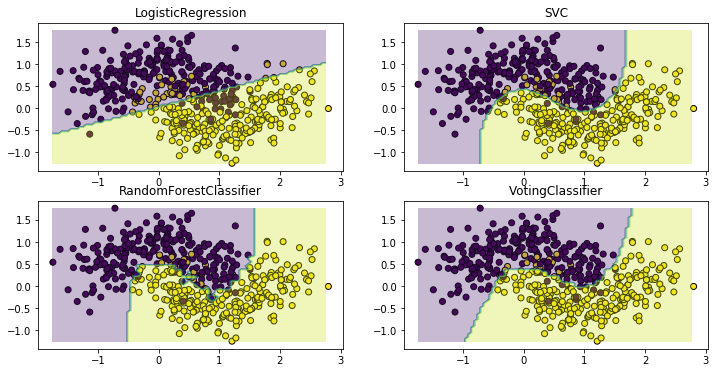

In [5]:
from itertools import product
fig,ax=plt.subplots(2,2,figsize=(12,6))

for index,modelo in zip(product([0,1],[0,1]),modelos):
    
    xx,yy,Z=obtener_fronteras(modelo.fit(X_train,y_train),X,y)
    
    ax[index[0],index[1]].scatter(X[:,0],X[:,1],c=y,edgecolors='black')
    
    ax[index[0],index[1]].contourf(xx,yy,Z,cmap='viridis',alpha=0.3)
    
    clase=modelo.__class__.__name__
    
    ax[index[0],index[1]].set_title(clase)
    
    
    


# Bagging and Pasting

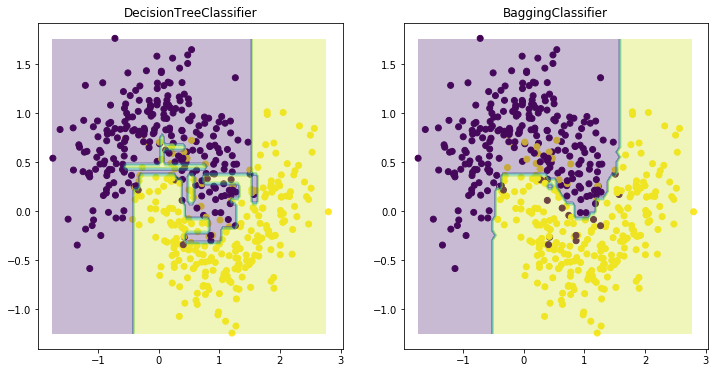

In [6]:
from sklearn.ensemble import BaggingClassifier;from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier(random_state=42)
bag=BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1)

models=[dtc,bag]

fig,ax=plt.subplots(1,2,figsize=(12,6))


for index,modelo in enumerate(models):
    ax[index].scatter(X[:,0],X[:,1],c=y)
    modelo.fit(X_train,y_train)
    xx,yy,Z=obtener_fronteras(modelo,X)
    clase=modelo.__class__.__name__
    ax[index].set_title(clase)
    ax[index].contourf(xx,yy,Z,cmap='viridis',alpha=0.3)
    

### BagginClassifier usa boostrap por defecto, entonces es posible que una muestra sea tomada varias veces en el proceso de muestreo, mientras que otras nunca sean tomadas. Dichas muestras que no son tomadas son desconocidas para el estimador y puede servir como cross-validation para el modelo.

In [7]:
y_pred=bag.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

In [8]:
bag=BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1,oob_score=True)
bag.fit(X_train,y_train)
bag.oob_score_


0.9253333333333333

In [9]:
y_pred=bag.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

### Vemos como se obtiene un mejor resultado sobre el conjunto de datos de testeo cuando  las muestras no tomadas durante el proceso de muestreo son utilizadas como cross validation.

# Random Forests

In [10]:
from sklearn.ensemble import RandomForestClassifier;from sklearn.model_selection import GridSearchCV

estimador=Pipeline([('rfc',RandomForestClassifier(random_state=42))])

params=[{'rfc__n_estimators':[100,250,500],'rfc__max_depth':[5,10,15],'rfc__max_leaf_nodes':[5,10,15,30]}]

grid=GridSearchCV(estimator=estimador,param_grid=params,cv=4,n_jobs=-1)

grid.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [11]:
y_pred=grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

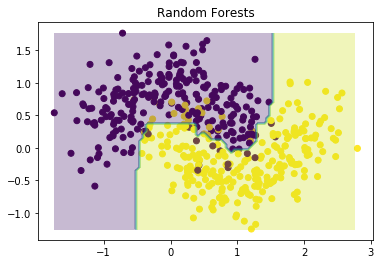

In [12]:
plt.scatter(X[:,0],X[:,1],c=y)
xx,yy,Z=obtener_fronteras(grid.best_estimator_,X)
clase=grid.best_estimator_.__class__.__name__
plt.title("Random Forests")
plt.contourf(xx,yy,Z,cmap='viridis',alpha=0.3)

### En la imágen anterior vemos que la superficie de decisión del estimador random forests es muy similar al estimador bagging cuando este es implementado con modelos decision tree. 

# Feature Importance

In [13]:
from sklearn.datasets import load_wine
data=load_wine()
data.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [14]:
X=data.data
y=data.target
modelo=RandomForestClassifier(n_estimators=500)
modelo.fit(X,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
modelo.feature_importances_

array([0.1082584 , 0.03065638, 0.01433284, 0.0264763 , 0.03433457,
       0.05322948, 0.15444467, 0.00991928, 0.02027678, 0.16216362,
       0.08328949, 0.12786349, 0.17475471])

In [16]:
for index,arg in enumerate(np.argsort(modelo.feature_importances_)[::-1]):
    print(f'{data.feature_names[arg]:30}{modelo.feature_importances_[arg]:.3f}')

proline                       0.175
color_intensity               0.162
flavanoids                    0.154
od280/od315_of_diluted_wines  0.128
alcohol                       0.108
hue                           0.083
total_phenols                 0.053
magnesium                     0.034
malic_acid                    0.031
alcalinity_of_ash             0.026
proanthocyanins               0.020
ash                           0.014
nonflavanoid_phenols          0.010


### En la lista vemos las características más importantes junto con su nivel de importancia. Se observa que las primeras 5 características ya contribuyen un 75% de importancia en el entrenamiento del modelo.

# Ada Boost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=400,
    algorithm="SAMME.R", learning_rate=0.1, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

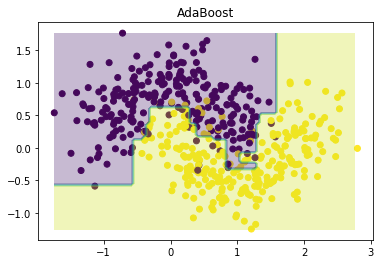

In [24]:
plt.scatter(X[:,0],X[:,1],c=y)
xx,yy,Z=obtener_fronteras(ada_clf,X)
plt.title("AdaBoost")
plt.contourf(xx,yy,Z,cmap='viridis',alpha=0.3)

In [25]:
accuracy_score(y_train,ada_clf.predict(X_train))

0.9493333333333334

In [26]:
accuracy_score(y_test,ada_clf.predict(X_test))

0.904